## Loading an ARG in tree sequence format

In [2]:
import tskit

In [3]:
ts = tskit.load("data/demo.trees")

In [4]:
ts

## Analysis 

Below are a few examples of analysing the loaded _tskit_ ARG. Feel free to change them and re-run the cells. Documentation for the methods is here: https://tskit.dev/tskit/docs/stable/python-api.html (e.g. see [here](https://tskit.dev/tskit/docs/stable/python-api.html#tskit.TreeSequence.allele_frequency_spectrum) for the allele frequency spectrum).

In [5]:
# Calculate the unpolarised allele frequency spectrum
afs = ts.allele_frequency_spectrum(polarised=False)
print(f"AFS calculated for {ts.num_samples} genomes of length {ts.sequence_length/1e6:.2f} Mb")

AFS calculated for 200 genomes of length 1.00 Mb


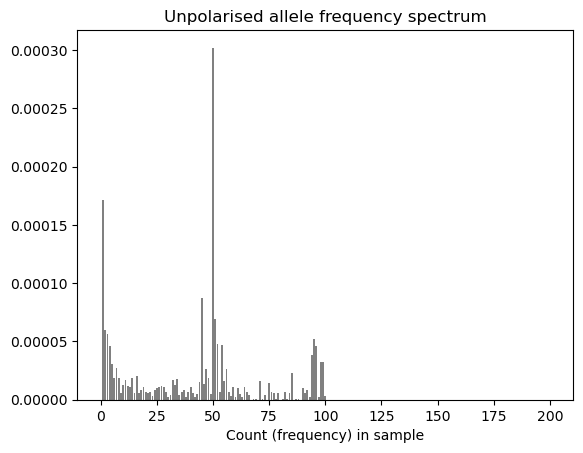

In [6]:
# and plot it
from matplotlib import pyplot as plt

plt.bar(range(ts.num_samples + 1), afs, color="grey")
plt.xlabel("Count (frequency) in sample")
plt.title("Unpolarised allele frequency spectrum");

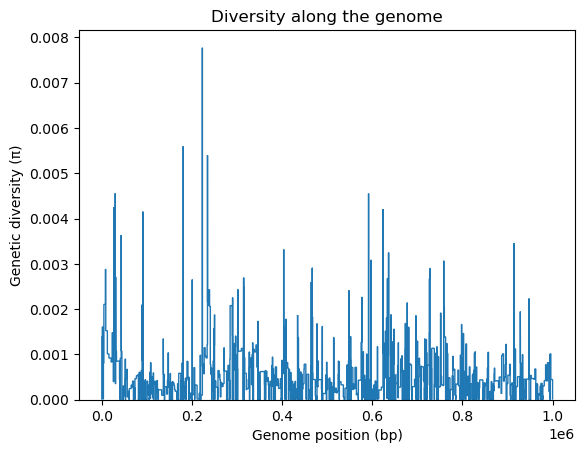

In [7]:
# Calculate windowed genetic diversity
windowed_diversity = ts.diversity(windows="trees")
plt.stairs(windowed_diversity, ts.breakpoints(as_array=True))
plt.ylabel("Genetic diversity (π)")
plt.xlabel("Genome position (bp)")
plt.title("Diversity along the genome");

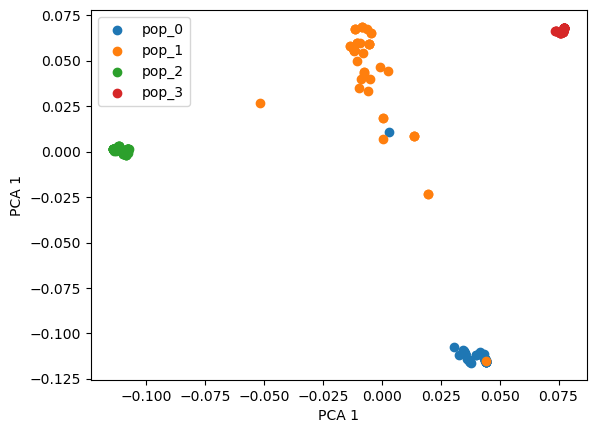

In [8]:
# Calculate the first 2 principle components
pca_output = ts.pca(2, mode="branch", random_seed=42)

# Plot the PCA
for population in ts.populations():
    use = ts.samples(population=population.id)
    plt.scatter(*pca_output.factors[use, :].T, label=population.metadata["name"])

plt.xlabel("PCA 1")
plt.ylabel("PCA 1")
plt.legend();

## Other analyses
This notebook is fully interactive. Feel free to run other analysis below. Tutorial material is avaiable at https://tskit.dev/tutorials/.

In [9]:
# Use this as a playground for trying out tskit
